In [1]:
from __future__ import division, print_function
import numpy, pylab, math
import icecube
from icecube import dataio
from icecube import dataclasses
from icecube import CascadeVariables
import os
%matplotlib inline

In [2]:
gcd=dataio.I3File("/data/sim/IceCube/2011/filtered/level2/neutrino-generator/10099/00000-00999/GeoCalibDetectorStatus_IC86.55697_corrected_V2.i3.gz")


In [3]:
gcd.rewind()
fr=gcd.pop_frame()
geo=fr.Get("I3Geometry")


In [4]:
NFiles=10
sigFilesI3=[]
sigDir="/data/user/dxu/batch/myjobs/EHE/level4a/cc_nutau/10099/outfile_reOP/update_07122016/"
sigFiles=os.listdir(sigDir)
for i in sigFiles:
    if(i.find(".i3.bz2")>0):
        sigFilesI3.append(i)

bgFilesI3=[]
bgDir="/data/user/dxu/batch/myjobs/EHE/level4a/nc_nutau/10099/outfile_reOP/update_07122016/"
bgFiles=os.listdir(bgDir)
for i in bgFiles:
    if(i.find(".i3.bz2")>0):
        bgFilesI3.append(i)


sigFilesI3=sigFilesI3[0:NFiles]
bgFilesI3=bgFilesI3[0:NFiles]

In [5]:
Count=0    
NoCascadesBG=0
Distances=[]
Waveforms=[]
Energies=[]
Times=[]
Charges=[]
MaxWFTimes=[]
BinWidths=[]

EnergyLimLow=5e3
EnergyLimHigh=1e6

for bgFile in bgFilesI3:
    Count=Count+1
    print("opening "+bgFile+",  "+str(Count)+" of " + str(len(bgFilesI3)))
    bgFile=dataio.I3File(bgDir+bgFile)
    bgFile.rewind()
    while(bgFile.more()):
        #pop a frame
        fr=bgFile.pop_physics()

        #grab the weight dict and event weight
        WeightDict=fr.Get("I3MCWeightDict")
        Weight=(365*24*3600)*1.0e-8*pow(WeightDict["PrimaryNeutrinoEnergy"], -2)*WeightDict["OneWeight"]/(WeightDict["NEvents"]*len(sigFilesI3))

        #Find the cascade center
        if not fr.Has("CascadeLlhVertexFit") :
            NoCascadesBG=NoCascadesBG+1
            continue

        if( WeightDict["PrimaryNeutrinoEnergy"]<EnergyLimLow) or (WeightDict["PrimaryNeutrinoEnergy"]>EnergyLimHigh):    
            continue
        csc=fr.Get('CascadeLlhVertexFit')
        cscpos=csc.pos

        #Get the waveforms
#        rd=fr.Get('In')
        wf=fr.Get('CalibratedWaveformsHLCATWD')
        DistancesThisEvt=[]
        WaveformsThisEvt=[]
        EnergiesThisEvt=[]
        TimesThisEvt=[]
        ChargesThisEvt=[]
        BinWidthsThisEvt=[]
        for om, wf_series in wf:
            for w in wf_series:
                if(w.status==0):
                    DOMPos=geo.omgeo[om].position
                    DistancesThisEvt.append((cscpos-DOMPos).r)
                    WaveformsThisEvt.append(w.waveform)
                    TimesThisEvt.append(w.time)
                    ChargesThisEvt.append(sum(w.waveform))
                    BinWidthsThisEvt.append(w.bin_width)
                    break
            Energies.append(csc.energy)
            Distances.append(DistancesThisEvt)
            Waveforms.append(WaveformsThisEvt)
            Charges.append(ChargesThisEvt)
            Times.append(TimesThisEvt)
            BinWidths.append(BinWidthsThisEvt)
            MaxWFTimes.append(TimesThisEvt[numpy.argmax(ChargesThisEvt)])

            

opening dp_Level4a_nugen_nutau_IC86.2011.010099.000131.i3.bz2,  1 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000326.i3.bz2,  2 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000496.i3.bz2,  3 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000007.i3.bz2,  4 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000784.i3.bz2,  5 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000861.i3.bz2,  6 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000986.i3.bz2,  7 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000287.i3.bz2,  8 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000295.i3.bz2,  9 of 10
opening dp_Level4a_nugen_nutau_IC86.2011.010099.000200.i3.bz2,  10 of 10


1000
2000
3000
4000
5000
6000
7000
8000


[]

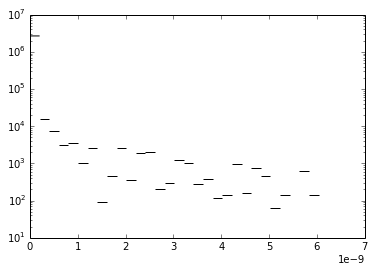

In [6]:
wfamps=[]
count=0
for wfe in Waveforms:
    count=count+1
    if(count%1000==0):
        print(count)
    for wf in wfe:
        wfamps.append(max(wf))
pylab.hist(wfamps,bins=30)
pylab.semilogy()

In [7]:
TimeShifts=[]
for tindex in range(0,len(Times)):
    StartTime=numpy.min(Times[tindex])
    TimeShifts.append((Times[tindex]-StartTime)/BinWidths[tindex])
    

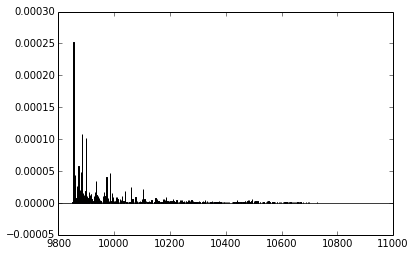

In [9]:
TimesFlat=[item for sublist in Times for item in sublist]
ChargesFlat=[item for sublist in Charges for item in sublist]
pylab.hist(TimesFlat, weights=ChargesFlat,bins=numpy.arange(9500,11000,1))

pylab.show()

In [10]:
therange=numpy.arange(0,128)

W_Normd=[]
W_Sum=[]

ylimlo=-40
ylimhi=120


DistanceLims=numpy.arange(0,250,25)
AveWFs=[]
for dis in range(0,len(DistanceLims)-1):
    NWF=0
    TotCharge=0
    WFLength=500
    AveWF=numpy.zeros(WFLength)

    for i in range(0,len(Waveforms)):
        for j in range(0,len(Waveforms[i])):
            if(DistanceLims[dis]<Distances[i][j] and DistanceLims[dis+1]>Distances[i][j]) and len(Waveforms[i][j])==128:
                Shift=int(TimeShifts[i][j])
                if(Shift<WFLength):
                    Charge=0
                    for w in range(0,min(128,(WFLength-Shift))):
                        AveWF[w+Shift]+=numpy.array(Waveforms[i][j][w])
                        Charge+=Waveforms[i][j][w]
                    TotCharge+=Charge
                    NWF+=1
    AveWFs.append(AveWF/TotCharge)

    print(NWF,TotCharge)
    


4445 0.000510012322028
26397 0.000892865035965
43918 0.00043067259877


KeyboardInterrupt: 

In [ ]:
pylab.figure(figsize=(5,5))
for i in range(0,5):
    pylab.plot(therange, AveWFs[i],label="{"+str(DistanceLims[i])+","+str(DistanceLims[i+1])+"} m")
pylab.legend(loc='lower center',title='Distance Range',fontsize=12)
pylab.xlabel("Time / ticks")
pylab.ylabel("Ave calibrated pulse")
pylab.xlim(0,128)
pylab.show()

pylab.figure(figsize=(5,5))
for i in range(5,10):
    pylab.plot(therange, AveWFs[i],label="{"+str(DistanceLims[i])+","+str(DistanceLims[i+1])+"} m")
pylab.legend(loc='lower center',title='Distance Range',fontsize=12)
pylab.xlim(0,128)
pylab.xlabel("Time / ticks")
pylab.ylabel("Ave calibrated pulse")
pylab.show()

pylab.figure(figsize=(5,5))
for i in range(10,15):
    pylab.plot(therange, AveWFs[i],label="{"+str(DistanceLims[i])+","+str(DistanceLims[i+1])+"} m")
pylab.legend(loc='lower center',title='Distance Range',fontsize=12)
pylab.xlim(0,128)
pylab.xlabel("Time / ticks")
pylab.ylabel("Ave calibrated pulse")
pylab.show()

pylab.figure(figsize=(5,5))
for i in range(15,20):
    pylab.plot(therange, AveWFs[i],label="{"+str(DistanceLims[i])+","+str(DistanceLims[i+1])+"} m")
pylab.legend(loc='lower center',title='Distance Range',fontsize=12)
pylab.xlim(0,128)
pylab.xlabel("Time / ticks")

pylab.ylabel("Ave calibrated pulse")
pylab.show()

In [ ]:
WFDictionary={}
AveWFs[0]=AveWFs[1]
for i in range(0, len(AveWFs)):
    WFDictionary[DistanceLims[i]]=AveWFs[i]
    

In [ ]:
import cPickle
KernelsFile=open("DOMKernelsATWD.dat",'w')
cPickle.dump(WFDictionary,KernelsFile)
KernelsFile.close()

In [ ]:
DonglianParams=["Amp1","Amp2","AmpTrailing","BinsToT1","BinsToT2","BinsTbT"]
ValuesSI={}
ValuesBG={}

for i in DonglianParams:
    ValuesSI[i]=[]
    ValuesBG[i]=[]
ValuesBG["weight"]=[]
ValuesSI["weight"]=[]


In [ ]:
Count=0
NoCascadesSI=0
for signalFile in sigFilesI3:
    Count=Count+1
    print("opening "+signalFile+",  "+str(Count)+" of " + str(len(sigFilesI3)))
    signalFile=dataio.I3File(sigDir+signalFile)
    signalFile.rewind()
    while(signalFile.more()):
        fr=signalFile.pop_physics()
        WeightDict=fr.Get("I3MCWeightDict")
        if not fr.Has("CascadeLlhVertexFit"):
            NoCascadesSI=NoCascadesSI+1
            continue

        csc=fr.Get('CascadeLlhVertexFit')
        cscpos=csc.pos
        Weight=(365*24*3600)*1.0e-8*pow(WeightDict["PrimaryNeutrinoEnergy"], -2)*WeightDict["OneWeight"]/(WeightDict["NEvents"]*len(sigFilesI3))
        if fr==None:
            break
        OMs=fr.Get("DP_OMs")
        for c in range(0,len(OMs)):
            o=OMs[c]
            DOMPos=geo.omgeo[o].position
            if((DOMPos-cscpos).r<75):
                for i in DonglianParams:
                    ValuesSI[i].append(fr.Get(i)[c])
                ValuesSI["weight"].append(Weight)

In [ ]:

Count=0    
NoCascadesBG=0
for bgFile in bgFilesI3:
    Count=Count+1
    print("opening "+bgFile+",  "+str(Count)+" of " + str(len(bgFilesI3)))
    bgFile=dataio.I3File(bgDir+bgFile)
    bgFile.rewind()
    while(bgFile.more()):
        fr=bgFile.pop_physics()
        WeightDict=fr.Get("I3MCWeightDict")
        if not fr.Has("CascadeLlhVertexFit"):
            NoCascadesBG=NoCascadesBG+1
            continue
        csc=fr.Get('CascadeLlhVertexFit')
        cscpos=csc.pos
        Weight=(365*24*3600)*1.0e-8*pow(WeightDict["PrimaryNeutrinoEnergy"], -2)*WeightDict["OneWeight"]/(WeightDict["NEvents"]*len(sigFilesI3))
        if fr==None:
            break
        OMs=fr.Get("DP_OMs")
        for c in range(0,len(OMs)):
            o=OMs[c]
            DOMPos=geo.omgeo[o].position
            if((DOMPos-cscpos).r<150):
                for i in DonglianParams:
                    ValuesBG[i].append(fr.Get(i)[c])
                ValuesBG["weight"].append(Weight)


In [ ]:
pylab.figure(figsize=(5,5))

MaxAmp1SI=[]
MaxAmp1BG=[]
for i in ValuesSI["Amp1"]:
    MaxAmp1SI.append(numpy.max(i))
for i in ValuesBG["Amp1"]:
    MaxAmp1BG.append(numpy.max(i))



pylab.hist(MaxAmp1BG,weights=ValuesBG["weight"],histtype='step',color='red')
pylab.hist(MaxAmp1SI,weights=ValuesSI["weight"],histtype='step',color='blue')
pylab.ylim(1e-1,1e4)
pylab.semilogy()
pylab.show()




In [ ]:
FlattenedSI={}
FlattenedBG={}

for i in DonglianParams:
    FlattenedSI[i]=[]
    for j in ValuesSI[i]:
        FlattenedSI[i]+=j
FlattenedSI["weights"]=[]
for j in ValuesSI["Amp1"]:
    Weights=numpy.ones_like(j).tolist()
    FlattenedSI["weights"]+=Weights

        
for i in DonglianParams:
    FlattenedBG[i]=[]
    for j in ValuesBG[i]:
        FlattenedBG[i]+=j
FlattenedBG["weights"]=[]
for j in ValuesBG["Amp1"]:
    Weights=numpy.ones_like(j).tolist()
    FlattenedBG["weights"]+=Weights



In [ ]:
pylab.hist(numpy.array(FlattenedSI["Amp1"])/numpy.array(FlattenedSI["Amp2"]),weights=FlattenedSI["weights"],histtype='step',bins=numpy.logspace(-15,15,10))
pylab.hist(numpy.array(FlattenedBG["Amp1"])/numpy.array(FlattenedBG["Amp2"]),weights=FlattenedBG["weights"],histtype='step',bins=numpy.logspace(-15,15,10))
pylab.loglog()

In [ ]:
csc.pos.x

In [ ]:
for i in DonglianParams:
    f, axarr = pylab.subplots(1, 2,figsize=(10,5))
    print(i)
    h1,bins,non=axarr[0].hist(FlattenedSI[i],weights=FlattenedSI["weights"],bins=50,histtype='step')
    h2,bins,non=axarr[0].hist(FlattenedBG[i],weights=FlattenedBG["weights"],bins=bins,histtype='step')
    axarr[0].semilogy()
    axarr[1].plot(bins[:-1],numpy.array(h2)/numpy.array(h1),'.',color='red')
    axarr[0].set_xlabel(i)
    axarr[0].set_ylabel("count")
    axarr[1].set_xlabel(i)
    axarr[1].set_ylabel("ratio, BG/SIG")

    pylab.show()

#    pylab.show()
#    print(i, min(FlattenedBG[i]),max(FlattenedBG[i]))

In [ ]:
ret[]

In [ ]:
for i in DonglianParams:
    f, axarr = pylab.subplots(1, 2,figsize=(10,5))
    print(i)
    h1,bins,non=axarr[0].hist(ValuesSI[i],weights=numpy.array(ValuesSI["weight"])/sum(ValuesSI["weight"]),bins=500,histtype='step',cumulative=True)
    h2,bins,non=axarr[0].hist(ValuesBG[i],weights=numpy.array(ValuesBG["weight"])/sum(ValuesBG["weight"]),bins=bins,histtype='step',cumulative=True)
#    axarr[0].semilogx()
    axarr[1].plot(bins[:-1],numpy.array(h2)/numpy.array(h1),'.',color='red')
    axarr[0].set_xlabel(i)
    axarr[0].set_ylabel("count")
    axarr[1].set_xlabel(i)
    axarr[1].set_ylabel("ratio, BG/SIG")
    pylab.show()
    f, axarr = pylab.subplots(1, 2,figsize=(10,5))
    print(i)
    h1,bins,non=axarr[0].hist(ValuesSI[i],weights=numpy.array(ValuesSI["weight"])/sum(ValuesSI["weight"]),bins=500,histtype='step',cumulative=-1)
    h2,bins,non=axarr[0].hist(ValuesBG[i],weights=numpy.array(ValuesBG["weight"])/sum(ValuesBG["weight"]),bins=bins,histtype='step',cumulative=-1)
#    axarr[0].semilogx()
    axarr[1].plot(bins[:-1],numpy.array(h2)/numpy.array(h1),'.',color='red')
    axarr[0].set_xlabel(i)
    axarr[0].set_ylabel("count")
    axarr[1].set_xlabel(i)
    axarr[1].set_ylabel("ratio, BG/SIG")
    pylab.show()